# Project Finding Donors for Charity ML

## Getting Started
In this project, I will employ several supervised algorithms of my choice to accurately model **_individuals' income_** using data collected from the 1994 U.S. Census. Afterwards, I will choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 

This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, I can infer this value from other publically available features.

The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

## Exploring the Data
Note that the last column from this dataset, 'income', will be the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [23]:
#Importing necessary libraries 
import pandas as pd 
from time import time
import numpy as np

#import supplementary visualization code visuals.py
import visuals as vs

#Seeing graphs inline
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Loading dataset
df = pd.read_csv('census.csv')
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
Investigating the dataset to determine how many individuals fit into either groups and showing the percentage of people making more than $50,000 a year. 

In [21]:
#Total number of records
n_records = len(df)

#Number of individuals making more than $50,000 anually 
n_greater_50k = len(df[df['income']=='>50K'])

#Number of individuals making at most 50k a year
n_at_most_50k = len(df[df['income']=='<=50K'])

#Percentage of individuals making more than 50k anually
greater_percent = n_greater_50k / n_records * 100 

print("Total number of records: {}".format(n_records))
print("Number of individuals making more than $50,000 annually: {}".format(n_greater_50k))
print("Number of individuals making at most $50,000 annually: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Number of individuals making more than $50,000 annually: 11208
Number of individuals making at most $50,000 annually: 34014
Percentage of individuals making more than $50,000: 24.78%


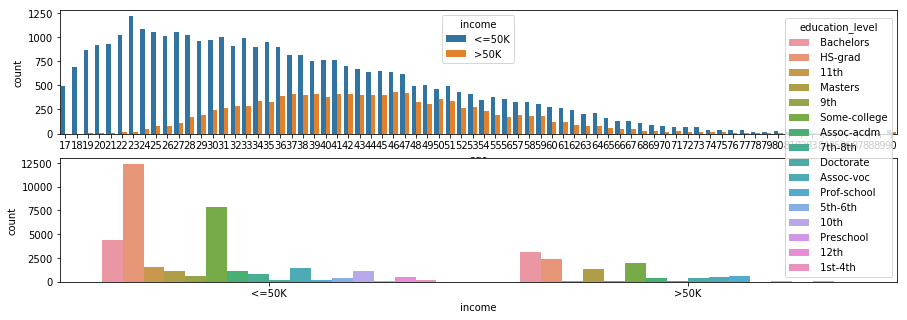

In [28]:
f,ax1 = plt.subplots(figsize=(15,5),nrows=2)
sns.countplot(x='age',hue='income',data=df,ax=ax1[0])
sns.countplot(x='income',hue='education_level',data=df,ax=ax1[1])

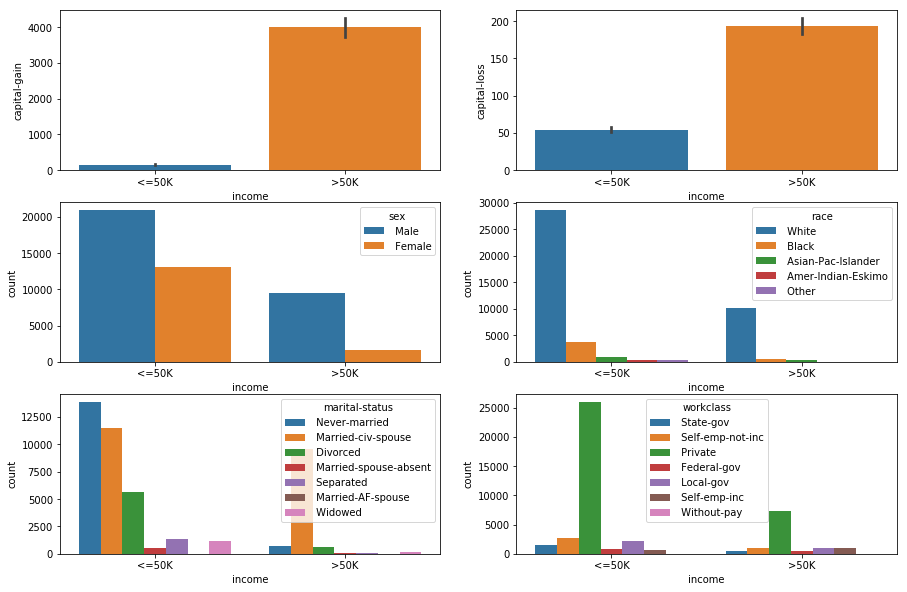

In [47]:
f,ax2 = plt.subplots(figsize=(15,10),ncols=2,nrows=3)
sns.barplot(x='income',y='capital-gain',data=df,ax=ax2[0][0])
sns.barplot(x='income',y='capital-loss',data=df,ax=ax2[0][1])
sns.countplot(x='income',hue='sex',data=df,ax=ax2[1][0])
sns.countplot(x='income',hue='race',data=df,ax=ax2[1][1])
sns.countplot(x='income',hue='marital-status',data=df,ax=ax2[2][0])
sns.countplot(x='income',hue='workclass',data=df,ax=ax2[2][1])

## Data Preprocessing
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **_preprocessing._**

Fortunately, for this dataset, there are no invalid or missing entries I have to deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. 

Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly **_normalized._** With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'.

Looking at the below, note the range of the values present and how they are distributed.

In [51]:
#Creating a function to plot distributitions to visualise skewness
#before transformation and AFTER transformation

def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

C:\Users\William X Nguyen\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


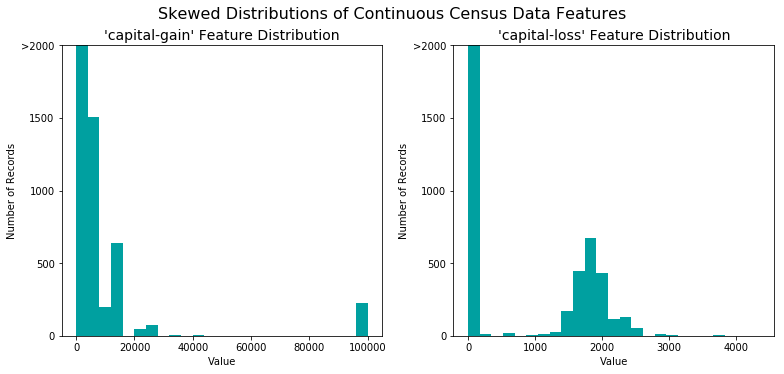

In [55]:
#Splitting data into features and target variable
income = df['income'] #Target variable
features = df.drop(['income'],axis=1)

#Visualising skewness continuous features of original data before
#any transformation has been done
distribution(features,transformed=False)

For highly-skewed feature distributions such as `capital-gain` and `capital-loss`, it is common practice to apply a **_logarithm transformation_** on the data so that very large and very small values don't negatively affect the performance of a learning algorithm.

Using a logarithm transformation significantly reduces the range of values caused by outliers. Care must be taken when applying logarithm transformation: The logarithm of `0` is undefined, so I might translate the values by a small amount ABOVE 0 to apply the logarithm successfully. 

C:\Users\William X Nguyen\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


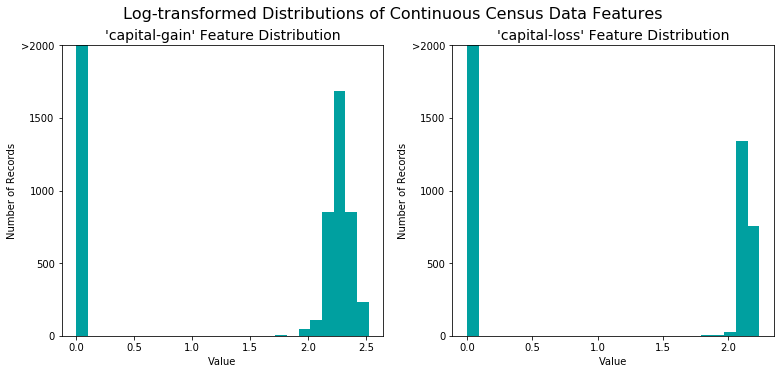

In [62]:
#Log-transformation of the skewed features
skewed = ['capital-gain','capital-loss']
features_log_transformed = pd.DataFrame(data=features)
features_log_transformed[skewed] = features[skewed].apply(lambda x: np.log(x+1))

#Visualising log distributions
distribution(features_log_transformed,transformed=True)


### Normalizing Numerical Features

In addition to performing **log transformations** on features that are highly skewed, it is often good practice to perform some type of _scaling on numerical features._ Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each **_feature is treated equally when applying supervised learners._** 

**Note:** That once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [72]:
#Importing StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Initalize a scaler and applying this scaler to numerical features
scaler = MinMaxScaler()
numerical_features = ['age','education-num','capital-gain',
             'capital-loss','hours-per-week']

#Creating data frame with log-transformed features
features_log_minmax_transform = pd.DataFrame(data=features_log_transformed)
features_log_minmax_transform[numerical_features].head()

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13.0,2.161573,0.0,40.0
1,50,13.0,0.000000,0.0,13.0
2,38,9.0,0.000000,0.0,40.0
3,53,7.0,0.000000,0.0,40.0
4,28,13.0,0.000000,0.0,40.0


In [75]:
#Fitting the scaler to log-transformed numerical features
features_log_minmax_transform[numerical_features] = scaler.fit_transform(features_log_transformed[numerical_features])

In [76]:
#Looking at how scaling was applied 
features_log_minmax_transform[numerical_features].head(n=10)

,age,education-num,capital-gain,capital-loss,hours-per-week
0,0.301370,0.800000,0.855471,0.0,0.397959
1,0.452055,0.800000,0.000000,0.0,0.122449
2,0.287671,0.533333,0.000000,0.0,0.397959
3,0.493151,0.400000,0.000000,0.0,0.397959
4,0.150685,0.800000,0.000000,0.0,0.397959
5,0.273973,0.866667,0.000000,0.0,0.397959
6,0.438356,0.266667,0.000000,0.0,0.153061
7,0.479452,0.533333,0.000000,0.0,0.448980
8,0.191781,0.866667,0.932576,0.0,0.500000
9,0.342466,0.800000,0.893155,0.0,0.397959


In [77]:
#Looking at the whole dataset
features_log_minmax_transform.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.855471,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing 

There are several features that are non-numeric. Typically, algorithms expect input to be **numeric**, which requires that non-features features (_categorical variables_) to be converted. 

One way to convert categorical variables is by using the **one-hot encoding** scheme:
- One-Hot encoding creates a "_dummy_" variable for each possible category of each non-numeric feature. 
- For example, a feature `someFeature` has three possible unique values `A,B or C`. One-Hot encoding encodes this feature into `someFeature_A`, `someFeature_B`, `someFeature_C`

Additionally, along with the non-numeric independent variables, need to convert the non-numeric target variable, `income` to numerical values for the learning algorithms to work. 
- Since, there are only two values for this label ("<=50k" and ">50k"), I won't use one-hot encoding and simply encode these two categories as 0 and 1. 

In [85]:
#One-hot encoding the 'features_log_minmax_transform' data 
features_final = pd.get_dummies(features_log_minmax_transform)

#Encoding the target variable 'income' to numerical 0 and 1 values
income = income.apply(lambda x: 1 if x == ">50K" else 0)

#The number of columns after one-hot encoding 
encoded = features_final.columns.tolist
print("{} total features after one-hot encoding.".format(len(encoded)))

TypeError: object of type 'method' has no len()

In [82]:
listfeatures_final.columns)

['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay',
 'education_level_ 10th',
 'education_level_ 11th',
 'education_level_ 12th',
 'education_level_ 1st-4th',
 'education_level_ 5th-6th',
 'education_level_ 7th-8th',
 'education_level_ 9th',
 'education_level_ Assoc-acdm',
 'education_level_ Assoc-voc',
 'education_level_ Bachelors',
 'education_level_ Doctorate',
 'education_level_ HS-grad',
 'education_level_ Masters',
 'education_level_ Preschool',
 'education_level_ Prof-school',
 'education_level_ Some-college',
 'marital-status_ Divorced',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'occupation_ Adm-cleri